In [1]:
"""This module implements the Fréchet regression method from Petersen and Müller 2019.

The method is implemented in the context of estimation in the space of distribution
functions. Also, a simulation study is designed to compare with the methods outlined in
Petersen and Müller 2016.

"""

'This module implements the Fréchet regression method from Petersen and Müller 2019.\n\nThe method is implemented in the context of estimation in the space of distribution\nfunctions. Also, a simulation study is designed to compare with the methods outlined in\nPetersen and Müller 2016.\n\n'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import quadprog

from frechet_fda.function_class import Function
from frechet_fda.tools.function_tools import mean_func

In [3]:
N = 200
# predictor = np.random.uniform(-1, 1, (2, N)) # for case of multiple predictors
predictor = np.random.uniform(-1, 1, N)
predictor.sort()

In [4]:
def mu_from_x(x, mu0, beta, v1):
    """Sample mus from the first simulation setting in Petersen & Müller (2019)."""

    return np.random.normal(loc = mu0 + beta * x, scale = v1)

In [5]:
mus = mu_from_x(predictor, 0, 3, 0.25)

In [6]:
def sigma_from_x(x, sigma0, gamma, v2):
    """Sample sigmas from the first simulation setting Petersen & Müller (2019)."""
    sh = (sigma0 + gamma * x) ** 2 / v2
    sc = v2 / (sigma0 + gamma * x)

    return np.random.gamma(shape=sh, scale=sc)

In [7]:
sigmas = sigma_from_x(predictor, 3, 0.5, 2)

In [8]:
grid_size = 500
delta = 0
u = np.linspace(delta, 1 - delta, grid_size)

In [9]:
def gen_y_qf(mu, sigma, eval_points):
    """Generate quantile function of Y_i given X_i."""
    ys = (
        mu[..., np.newaxis]
        + sigma[..., np.newaxis]
        * norm.ppf(eval_points)[np.newaxis, ...]
    )
    return [Function(eval_points, y) for y in ys]

In [10]:
qfs = gen_y_qf(mus, sigmas, u)

In [11]:
qfs[0].y.shape

(500,)

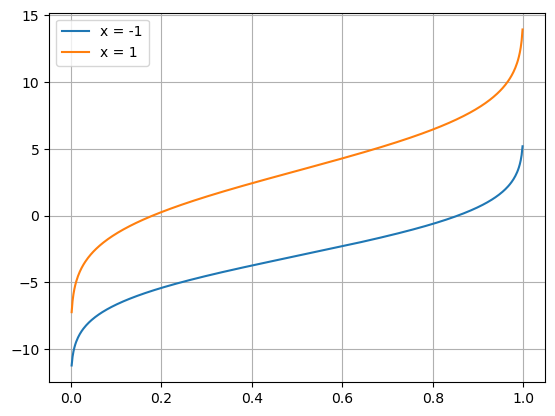

In [12]:
qfs[0].compare(qfs[199], label_self="x = -1", label_other="x = 1")

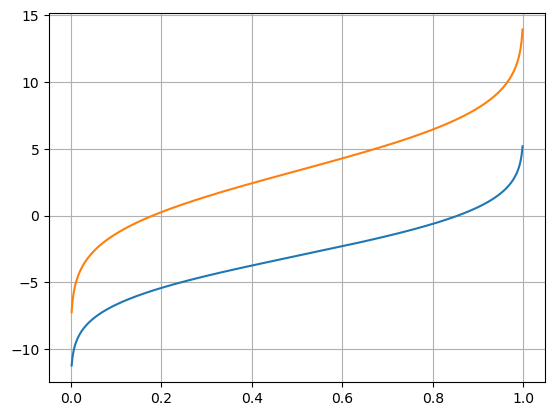

In [13]:
fig, ax = plt.subplots()
ax.plot(qfs[0].x, qfs[0].y)
ax.plot(qfs[199].x, qfs[199].y)
plt.grid()
plt.show()

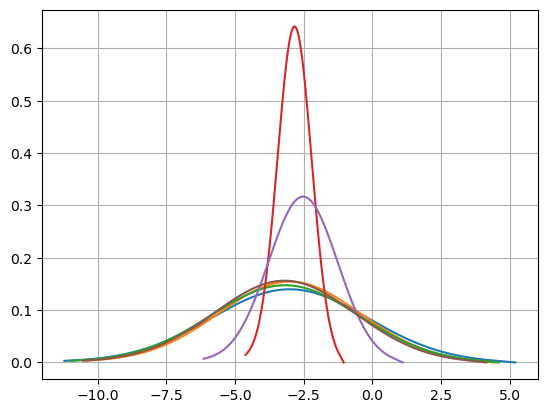

In [14]:
fig, ax = plt.subplots()
for qf in qfs[:6]:
    pdf = qf.invert().differentiate()
    ax.plot(
    pdf.x,
    pdf.y,
)
plt.grid()
plt.show()

In [15]:
def _empirical_weight_function(x_eval, predictor_values):
    """Weight function to compute weighted Fréchet mean."""
    predictor_values = np.atleast_2d(predictor_values)
    means = np.mean(predictor_values, axis = -1)
    cov_matrix = (
        predictor_values @ predictor_values.transpose()
        / predictor_values.shape[-1]
    )
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    s_in = 1 + (
        (predictor_values - means[..., np.newaxis]).transpose()
        @ inv_cov_matrix
        @ (x_eval - means)
    )
    return s_in

In [16]:
def qf_tilde(quantile_funcs, x, predictor_values):
    """Estimator for quantile function."""
    return mean_func(_empirical_weight_function(x, predictor_values) * quantile_funcs).y

In [17]:
x_grid = np.linspace(-1, 1, 20)

In [18]:
def solve_qp(u, x_grid, x_observed, quantile_functions) -> list[Function]:
    """Sets up quadratic programming problem"""
    grid_size = len(u)
    qp_g = np.identity(grid_size)   # make sure P is symmetric
    qp_c = np.eye(grid_size, grid_size-1, k=-1) - np.eye(grid_size, grid_size-1)
    qp_b = np.zeros(grid_size-1)
    estimates = []
    for x in x_grid:
        qp_a = qf_tilde(quantile_functions, x, x_observed)
        constraints_check = qp_a[1:] - qp_a[:-1]
        # remove nans
        constraints_check = constraints_check[~np.isnan(constraints_check)]
        if np.all(constraints_check > 0):
            # If estimator valid qf, it is the optimal solution
            solution = qp_a
        else:
            # Else, find closest vector to estimator that is valid solution
            solution = quadprog.solve_qp(qp_g, qp_a, qp_c, qp_b)[0]
        estimates.append(Function(u, solution))
    return estimates

In [19]:
estimates = solve_qp(u, x_grid, predictor, qfs)

C:\Coding\frechet_fda\src\frechet_fda\function_class.py:217: RuntimeWarning: invalid value encountered in add
  comb_y = np.interp(comb_x, x, y) + np.interp(comb_x, val.x, val.y)


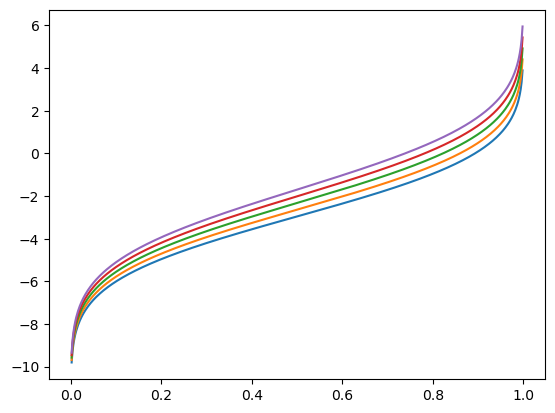

In [20]:
for func in estimates[:5]:
    plt.plot(func.x, func.y)

c:\Anaconda3\envs\frechet_fda\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


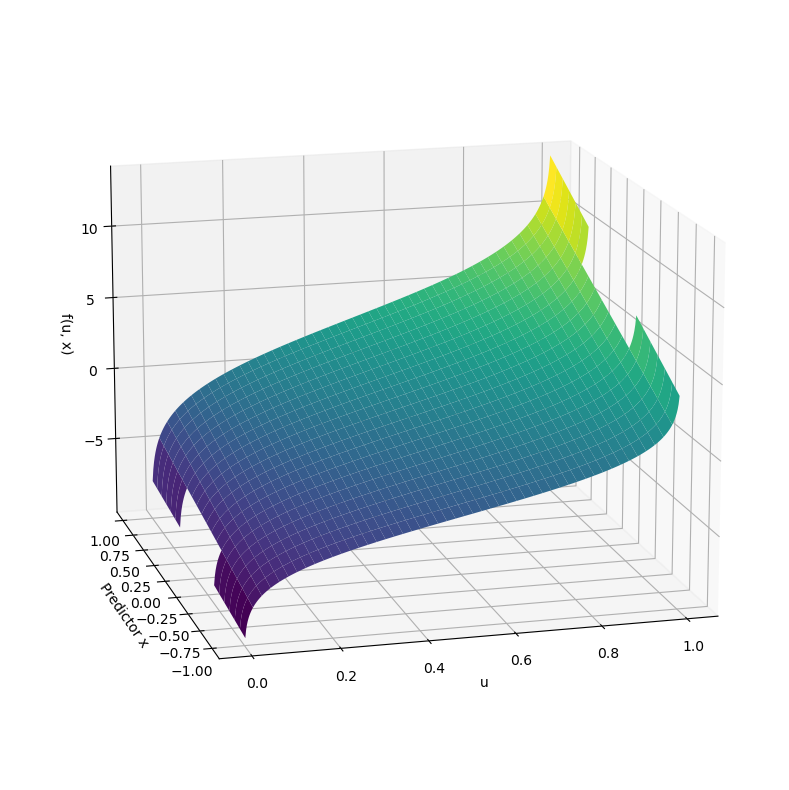

In [21]:
# Initialize a 2D array to hold f(u, x) values
z_values = np.zeros((len(x_grid), len(func.x)))

# Populate the array with estimates
for i, func in enumerate(estimates):
    z_values[i] = func.y

# Create the 3D surface plot
X, Y = np.meshgrid(func.x, x_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z_values, cmap='viridis')

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=255)

ax.set_xlabel('u')
ax.set_ylabel('Predictor x')
ax.set_zlabel('f(u, x)', rotation = 0)
# ax.zaxis.set_rotate_label(False)  # disable automatic rotation
# ax.set_zlabel('label text', rotation=0)
plt.tight_layout()
plt.show()

## Functional Regression with Transformation method

In [22]:
from frechet_fda.tools.function_tools import (
    log_qd_transform,
    inverse_log_qd_transform,
)

In [23]:
mus[:5], sigmas[:5]

(array([-3.00877887, -3.01435733, -3.18028714, -2.83561912, -2.52366117]),
 array([2.85275377, 2.58073197, 2.7027234 , 0.62137969, 1.25875259]))

C:\Coding\frechet_fda\src\frechet_fda\function_class.py:94: RuntimeWarning: invalid value encountered in add
  int_y += self.initial_value


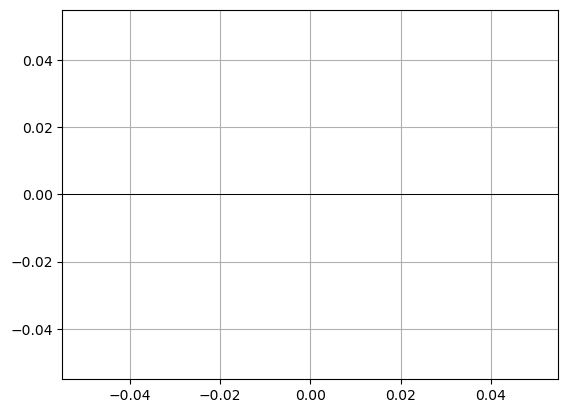

In [24]:
qfs[199].differentiate().integrate().plot()

In [25]:
pdfs = [qf.drop_inf().invert().differentiate() for qf in qfs]
pdfs_normalized = [pdf.standardize_support() for pdf in pdfs]
lqdfs = log_qd_transform(pdfs_normalized)

In [26]:
a1 = pdfs[0].x[0]
b1 = pdfs[0].x[-1]
a2 = pdfs[5].x[0]
b2 = pdfs[5].x[-1]
new_x1 = (pdfs[0].x - a1) / (b1 - a1)
new_x2 = (pdfs[5].x - a2) / (b2 - a2)
new_y1 = (b1 - a1) * np.interp(a1 + (b1 - a1) * new_x1, pdfs[0].x, pdfs[0].y)
new_y2 = (b2 - a2) * np.interp(a2 + (b2 - a2) * new_x2, pdfs[5].x, pdfs[5].y)
new_y1[:5], new_y2[:5]

(array([0.05100103, 0.0824058 , 0.11169833, 0.13964697, 0.16657634]),
 array([0.05100103, 0.0824058 , 0.11169833, 0.13964697, 0.16657634]))

In [27]:
predictor_matrix = np.array((np.ones(len(predictor)), predictor)).transpose()
predictor_matrix.shape, np.linalg.inv(predictor_matrix.transpose() @ predictor_matrix).shape

((200, 2), (2, 2))

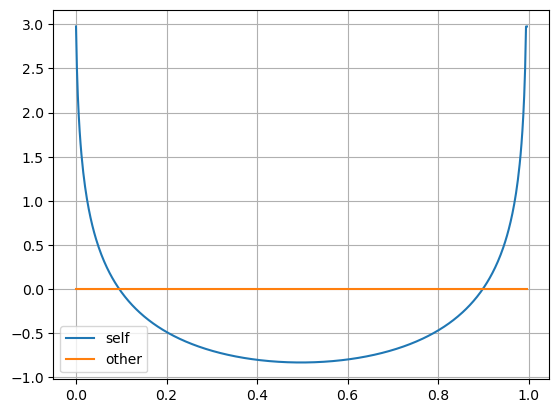

In [28]:
log_betahat = (
    np.linalg.inv(predictor_matrix.transpose() @ predictor_matrix)
    @ predictor_matrix.transpose() @ lqdfs
)
log_betahat0 = log_betahat[0]
log_betahat1 = log_betahat[1]
log_betahat0.compare(log_betahat1)

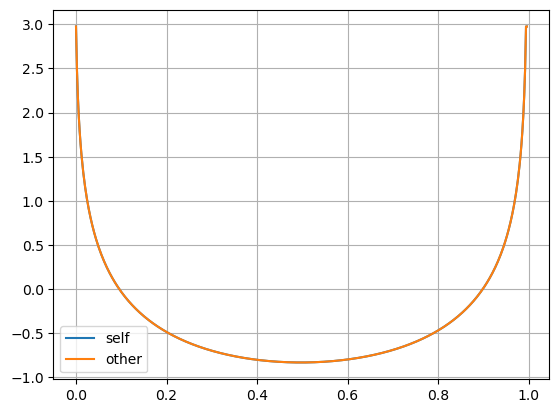

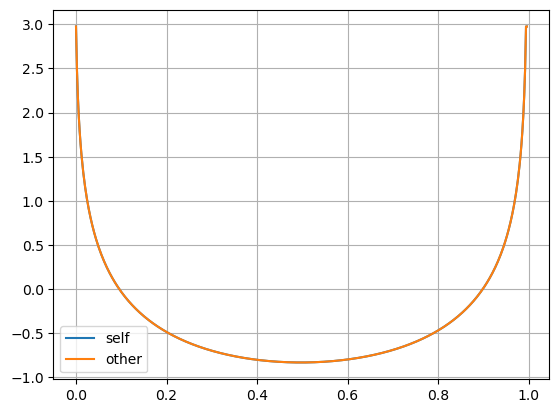

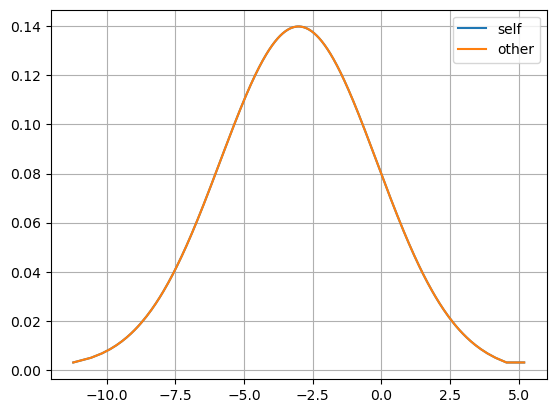

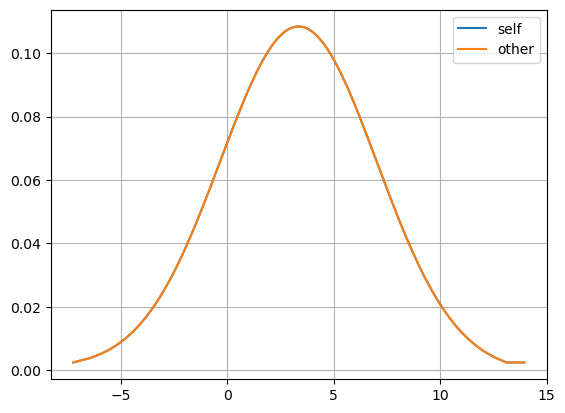

In [30]:
lqdf_hat = (predictor * log_betahat1 + log_betahat0)
# inverse_log_qd_transform(log_betahat)[0].plot()
lqdfs[0].compare(lqdf_hat[0])
lqdfs[199].compare(lqdf_hat[199])
pdf_hat = inverse_log_qd_transform(lqdf_hat)
# pdf_hat[0].integrate().invert().plot()
pdfs_normalized[0].rescale_back().compare(pdf_hat[0].rescale_back(a = pdfs[0].x[0], b = pdfs[0].x[-1]))
pdfs_normalized[199].rescale_back().compare(pdf_hat[199].rescale_back(a = pdfs[199].x[0], b = pdfs[199].x[-1]))

In [57]:
mus[0], mus[99], mus[199], sigmas[0], sigmas[99], sigmas[199]

(-2.73913182031185,
 0.2591916970461255,
 3.0429417671764307,
 2.117268119158205,
 3.0497005031918425,
 3.4810395472258526)

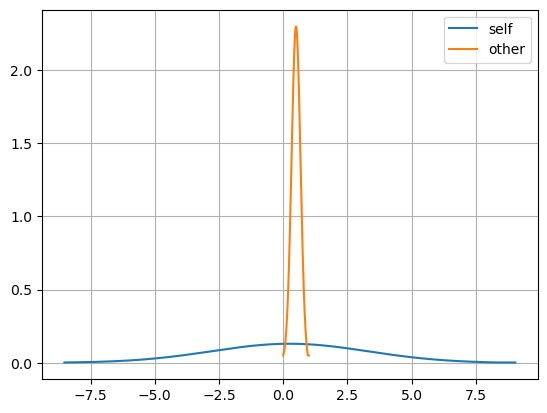

In [58]:
pdfs[99].compare(pdf_hat[99])

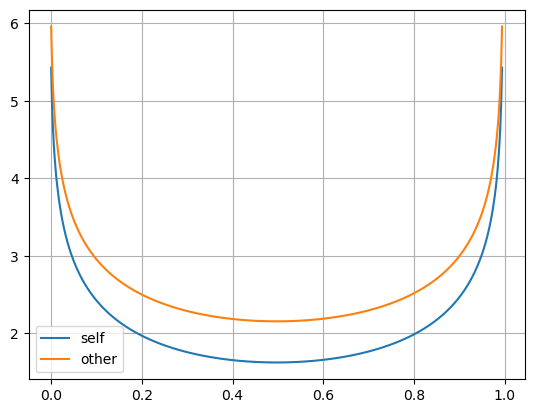

In [ ]:
lqdf_hat[0].compare(lqdf_hat[199])

In [ ]:
# Number of simulations
m = 5
# Number of samples of densities to generate
sample_sizes = [200]
# Number of sample points to generate from each density for density estimation step
points_number = 100
# Bandwidth choice for density estimation
bandwidth_choice = 0.2
# Fineness of grids to evaluate functions
grid_size = 1000
# Where to truncate normal distribution
trunc = 3
# 
threshold_variance_explained = 0.9
# Initialize arrays to store Fréchet and cross sectional means
stored_f_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_f_means_denstimation = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means_denstimation = np.empty((m, len(sample_sizes)), dtype="object")

In [ ]:
total_iterations = m * len(sample_sizes)  # Total iterations
current_iteration = 0  # Initialize a counter for the current iteration
print("Simulating...", end="\r")
for i in range(m):
    # Try different sample sizes
    for j, n in enumerate(sample_sizes):
        # j index only used for storing Fréchet means below!
        # Set parameters
        seed_num = int(str(i) + str(j))  # unique seed in each simulation run
        mus, sigmas = gen_params_scenario_one(n, seed=seed_num)
        # Sort sigmas just for inspection reasons
        sigmas.sort()

        # Generate pdfs within truncation points
        pdfs = make_truncnorm_pdf(
            -trunc,
            trunc,
            mus,
            sigmas,
            grid_size=grid_size,
            warn_irregular_densities=False,
        )
        # Make Function class objects
        my_pdfs = make_function_objects(pdfs)

        # For numerical correction: shorten the range for smaller sigmas to get rid of
        # numerical artifacts when computing integrals, derivatives and means later
        new_ranges = get_optimal_range(my_pdfs)
        # Generate pdfs again, this time within individual ranges
        pdfs2 = [
            make_truncnorm_pdf(
                new_ranges[i][0],
                new_ranges[i][1],
                mus[i],
                sigmas[i],
                grid_size=grid_size,
                warn_irregular_densities=False,
            )[0]
            for i in range(n)
        ]

        # Generate numerically stable objects
        new_pdfs = make_function_objects(pdfs2)

        # Compute Fréchet mean
        stored_f_means[i, j] = frechet_mean(new_pdfs)
        stored_cs_means[i, j] = mean_func(new_pdfs)

        # Compute Fréchet variance
        total_variance = total_frechet_variance(stored_f_means[i, j], new_pdfs)

        # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdfs)
        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs, k=2)

        # Try function that finds optimal trunc representation. Threshold: explain
        # at least threshold_variance_explained
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            threshold_variance_explained,
            total_variance,
            new_pdfs,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        )

        ### And now again with additional density estimation step!
        which_kernel = "std_normal"
        sample_points = gen_truncnorm_pdf_points(
            -trunc, trunc, mus, sigmas, points_number
        )
        pdf_hats = make_estimated_truncnorm_pdf(
            sample_points=sample_points,
            a=-trunc * np.ones(n),
            b=trunc * np.ones(n),
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=bandwidth_choice,
        )

        new_ranges = get_optimal_range(pdf_hats)
        # Generate numerically stable objects, within individual ranges
        new_pdf_hats = make_estimated_truncnorm_pdf(
            sample_points=sample_points,
            a=new_ranges[:, 0],
            b=new_ranges[:, 1],
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=bandwidth_choice,
        )

        # Compute Fréchet mean
        stored_f_means_denstimation[i, j] = frechet_mean(new_pdf_hats)
        stored_cs_means_denstimation[i, j] = mean_func(new_pdf_hats)

        # Compute Fréchet variance
        total_variance = total_frechet_variance(
            stored_f_means_denstimation[i, j], new_pdf_hats,
        )

        # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdf_hats)

        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs, k=2)

        # Try function that finds optimal trunc representation. Threshold: explain
        # at least threshold_variance_explained
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            threshold_variance_explained,
            total_variance,
            new_pdf_hats,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        )

        # Print progress of simulation
        current_iteration += 1  # Increment the current iteration
        perc = int(100 * current_iteration / total_iterations)
        print(f"Simulating...{perc}%", end="\r")

NameError: name 'gen_params_scenario_one' is not defined